# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [212]:
# !pip install pyforest
# 1-Import Libraies+
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [213]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [214]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [215]:
df = df.rename(columns={'ipn31152n':'amount'})

In [216]:
df.head()

amount
DATE              
1972-01-01  59.962
1972-02-01  67.061
1972-03-01  74.235
1972-04-01  78.112
1972-05-01  84.764

In [217]:
df.tail()

amount
DATE              
2019-05-01 114.561
2019-06-01 124.960
2019-07-01 110.263
2019-08-01 102.609
2019-09-01 101.587

In [218]:
df.describe().T

count    mean    std    min    25%     50%     75%     max
amount 573.000 109.896 27.951 58.660 88.936 107.643 128.278 196.174

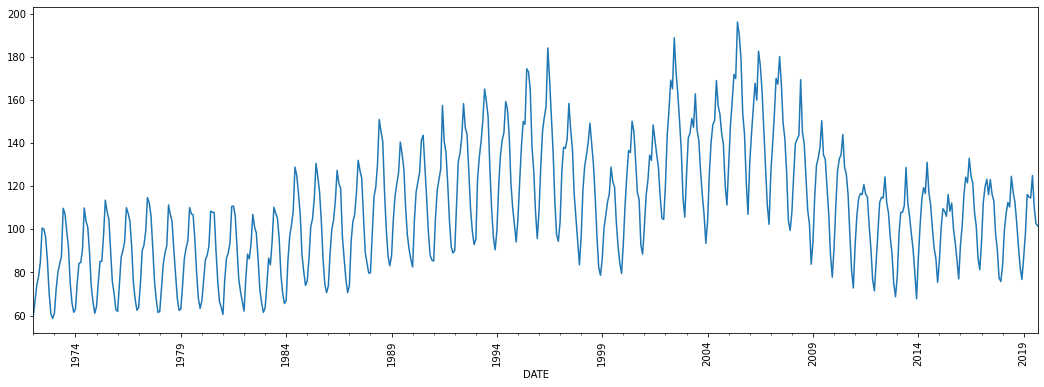

In [219]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

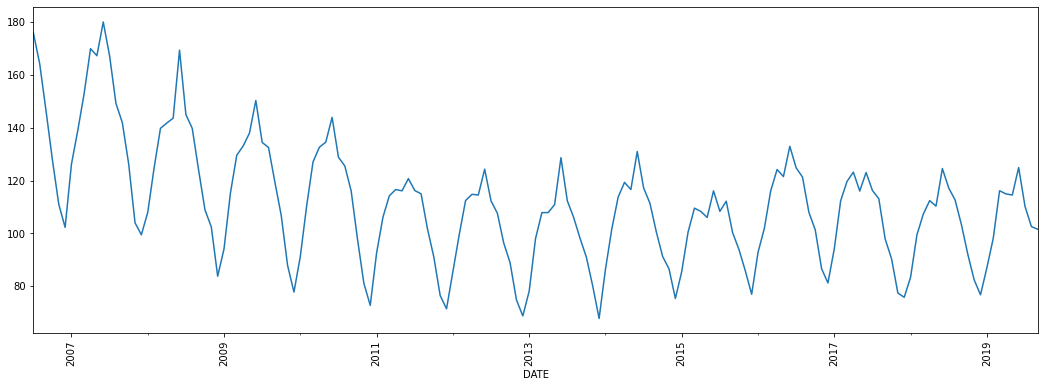

In [220]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### 3. Check missing values

In [221]:
missing_values(df)

Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []

### 4. Preprocessing of Data

### Train Test Split

In [222]:
len(df)

573

In [223]:
len(df)- 72

501

In [224]:
test_size = 72

In [225]:
test_ind = len(df)- test_size

In [226]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [227]:
train

amount
DATE              
1972-01-01  59.962
1972-02-01  67.061
1972-03-01  74.235
1972-04-01  78.112
1972-05-01  84.764
1972-06-01 100.596
1972-07-01 100.126
1972-08-01  96.361
1972-09-01  85.801
1972-10-01  70.393
1972-11-01  60.807
1972-12-01  58.660
1973-01-01  61.100
1973-02-01  72.206
1973-03-01  80.098
1973-04-01  83.906
1973-05-01  87.371
1973-06-01 109.747
1973-07-01 107.375
1973-08-01  99.663
1973-09-01  91.627
1973-10-01  75.305
1973-11-01  65.934
1973-12-01  61.530
1974-01-01  62.980
1974-02-01  75.345
1974-03-01  84.268
1974-04-01  84.588
1974-05-01  90.540
1974-06-01 109.903
1974-07-01 103.890
1974-08-01 101.026
1974-09-01  89.476
1974-10-01  73.695
1974-11-01  66.157
1974-12-01  61.065
1975-01-01  64.266
1975-02-01  75.417
1975-03-01  85.169
1975-04-01  85.092
1975-05-01  97.355
1975-06-01 113.525
1975-07-01 108.145
1975-08-01 104.825
1975-09-01  90.116
1975-10-01  75.719
1975-11-01  70.217
1975-12-01  62.744
1976-01-01  61.942
1976-02-01  74.060
1976-03-01  86.965
1976-04-01  90.131
1976-05-01  94.154
1976-06-01 110.026
1976-07-01 107.462
1976-08-01 103.818
1976-09-01  92.238
1976-10-01  75.103
1976-11-01  67.532
1976-12-01  62.483
1977-01-01  63.768
1977-02-01  75.061
1977-03-01  90.021
1977-04-01  92.665
1977-05-01  99.120
1977-06-01 114.723
1977-07-01 112.330
1977-08-01 106.414
1977-09-01  91.722
1977-10-01  76.025
1977-11-01  67.394
1977-12-01  61.441
1978-01-01  61.888
1978-02-01  72.871
1978-03-01  83.931
1978-04-01  89.059
1978-05-01  92.452
1978-06-01 111.326
1978-07-01 106.925
1978-08-01 103.691
1978-09-01  90.620
1978-10-01  79.184
1978-11-01  67.885
1978-12-01  62.403
1979-01-01  63.012
1979-02-01  73.941
1979-03-01  86.427
1979-04-01  91.203
1979-05-01  94.701
1979-06-01 110.103
1979-07-01 107.154
1979-08-01 106.773
1979-09-01  95.316
1979-10-01  79.598
1979-11-01  67.893
1979-12-01  63.285
1980-01-01  66.983
1980-02-01  76.444
1980-03-01  85.890
1980-04-01  87.998
1980-05-01  92.173
1980-06-01 108.467
1980-07-01 107.874
1980-08-01 107.857
1980-09-01  90.669
1980-10-01  76.228
1980-11-01  66.487
1980-12-01  63.865
1981-01-01  60.560
1981-02-01  76.485
1981-03-01  86.615
1981-04-01  89.034
1981-05-01  93.698
1981-06-01 110.684
1981-07-01 110.784
1981-08-01 106.120
1981-09-01  91.471
1981-10-01  76.925
1981-11-01  71.028
1981-12-01  66.599
1982-01-01  62.075
1982-02-01  77.029
1982-03-01  88.503
1982-04-01  86.244
1982-05-01  93.338
1982-06-01 106.934
1982-07-01 101.146
1982-08-01  98.201
1982-09-01  86.186
1982-10-01  72.074
1982-11-01  66.028
1982-12-01  61.469
1983-01-01  63.526
1983-02-01  74.365
1983-03-01  86.651
1983-04-01  83.531
1983-05-01  94.351
1983-06-01 110.226
1983-07-01 107.551
1983-08-01 105.297
1983-09-01  95.891
1983-10-01  79.065
1983-11-01  70.355
1983-12-01  65.587
1984-01-01  67.001
1984-02-01  85.614
1984-03-01  96.775
1984-04-01 101.825
1984-05-01 108.334
1984-06-01 128.840
1984-07-01 125.127
1984-08-01 116.608
1984-09-01 106.888
1984-10-01  88.263
1984-11-01  80.385
1984-12-01  73.974
1985-01-01  76.174
1985-02-01  86.612
1985-03-01 101.235
1985-04-01 104.867
1985-05-01 114.318
1985-06-01 130.597
1985-07-01 124.517
1985-08-01 117.446
1985-09-01 104.065
1985-10-01  86.226
1985-11-01  74.659
1985-12-01  70.633
1986-01-01  73.682
1986-02-01  88.936
1986-03-01 100.029
1986-04-01 104.301
1986-05-01 113.296
1986-06-01 127.323
1986-07-01 121.323
1986-08-01 119.079
1986-09-01  96.870
1986-10-01  86.412
1986-11-01  76.972
1986-12-01  70.620
1987-01-01  73.948
1987-02-01  94.537
1987-03-01 103.602
1987-04-01 106.819
1987-05-01 116.811
1987-06-01 132.008
1987-07-01 127.404
1987-08-01 123.675
1987-09-01 106.722
1987-10-01  89.404
1987-11-01  84.630
1987-12-01  79.702
1988-01-01  79.900
1988-02-01  98.017
1988-03-01 115.092
1988-04-01 119.372
1988-05-01 130.041
1988-06-01 150.930
1988-07-01 145.441
1988-08-01 140.743
1988-09-01 117.383
1988-10-01 100.098
1988-11-01  87.776
1988-12-01  83.095
1989-01-01  87.618
1989-02-01 104.350
1989-03-01 115.434
1989-04-01 121.182
1989-05-01 126.101
198

In [228]:
test

amount
DATE              
2013-10-01  90.998
2013-11-01  80.069
2013-12-01  67.803
2014-01-01  86.397
2014-02-01 101.731
2014-03-01 113.776
2014-04-01 119.353
2014-05-01 116.631
2014-06-01 131.040
2014-07-01 117.272
2014-08-01 111.418
2014-09-01 100.617
2014-10-01  91.261
2014-11-01  86.572
2014-12-01  75.375
2015-01-01  85.577
2015-02-01 100.558
2015-03-01 109.579
2015-04-01 108.362
2015-05-01 106.058
2015-06-01 116.138
2015-07-01 108.378
2015-08-01 112.205
2015-09-01 100.348
2015-10-01  93.932
2015-11-01  85.864
2015-12-01  76.975
2016-01-01  92.811
2016-02-01 101.974
2016-03-01 116.179
2016-04-01 124.211
2016-05-01 121.543
2016-06-01 132.987
2016-07-01 124.851
2016-08-01 121.332
2016-09-01 108.036
2016-10-01 101.384
2016-11-01  86.665
2016-12-01  81.257
2017-01-01  94.245
2017-02-01 112.388
2017-03-01 119.698
2017-04-01 123.228
2017-05-01 116.064
2017-06-01 123.087
2017-07-01 116.264
2017-08-01 113.172
2017-09-01  97.912
2017-10-01  90.473
2017-11-01  77.438
2017-12-01  75.812
2018-01-01  83.434
2018-02-01  99.490
2018-03-01 107.315
2018-04-01 112.431
2018-05-01 110.354
2018-06-01 124.584
2018-07-01 117.222
2018-08-01 112.678
2018-09-01 103.312
2018-10-01  92.132
2018-11-01  82.435
2018-12-01  76.761
2019-01-01  86.999
2019-02-01  98.112
2019-03-01 116.172
2019-04-01 114.970
2019-05-01 114.561
2019-06-01 124.960
2019-07-01 110.263
2019-08-01 102.609
2019-09-01 101.587

### Scaling

In [229]:
from sklearn.preprocessing import StandardScaler

In [230]:
scaler = StandardScaler()

In [231]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [232]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [233]:
# help(TimeseriesGenerator)

In [234]:
length = 24
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 4)

In [235]:
generator[0]

(array([[[-1.7428696 ],
         [-1.49951581],
         [-1.25354961],
         [-1.1206329 ],
         [-0.8925935 ],
         [-0.34980513],
         [-0.36590803],
         [-0.49500557],
         [-0.85703819],
         [-1.38525269],
         [-1.71390014],
         [-1.78752029],
         [-1.70387568],
         [-1.32310376],
         [-1.05253237],
         [-0.92199836],
         [-0.80319612],
         [-0.03608809],
         [-0.11740487],
         [-0.3817881 ],
         [-0.65728601],
         [-1.21686981],
         [-1.53812919],
         [-1.68910639]],
 
        [[-1.49951581],
         [-1.25354961],
         [-1.1206329 ],
         [-0.8925935 ],
         [-0.34980513],
         [-0.36590803],
         [-0.49500557],
         [-0.85703819],
         [-1.38525269],
         [-1.71390014],
         [-1.78752029],
         [-1.70387568],
         [-1.32310376],
         [-1.05253237],
         [-0.92199836],
         [-0.80319612],
         [-0.03608809],
         [-0.

In [236]:
train_scaled

array([[-1.74286960e+00],
       [-1.49951581e+00],
       [-1.25354961e+00],
       [-1.12063290e+00],
       [-8.92593496e-01],
       [-3.49805126e-01],
       [-3.65908035e-01],
       [-4.95005574e-01],
       [-8.57038190e-01],
       [-1.38525269e+00],
       [-1.71390014e+00],
       [-1.78752029e+00],
       [-1.70387568e+00],
       [-1.32310376e+00],
       [-1.05253237e+00],
       [-9.21998361e-01],
       [-8.03196124e-01],
       [-3.60880940e-02],
       [-1.17404871e-01],
       [-3.81788102e-01],
       [-6.57286009e-01],
       [-1.21686981e+00],
       [-1.53812919e+00],
       [-1.68910639e+00],
       [-1.63942290e+00],
       [-1.21550533e+00],
       [-9.09574059e-01],
       [-8.98603374e-01],
       [-6.94576054e-01],
       [-3.07467416e-02],
       [-2.36865349e-01],
       [-3.35046126e-01],
       [-7.31029584e-01],
       [-1.27205579e+00],
       [-1.53048057e+00],
       [-1.70505160e+00],
       [-1.59532417e+00],
       [-1.21301293e+00],
       [-8.7

In [237]:
X, y = generator[0]

In [238]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.7428696  -1.49951581 -1.25354961 -1.1206329  -0.8925935  -0.34980513
 -0.36590803 -0.49500557 -0.85703819 -1.38525269 -1.71390014 -1.78752029
 -1.70387568 -1.32310376 -1.05253237 -0.92199836 -0.80319612 -0.03608809
 -0.11740487 -0.3817881  -0.65728601 -1.21686981 -1.53812919 -1.68910639
 -1.49951581 -1.25354961 -1.1206329  -0.8925935  -0.34980513 -0.36590803
 -0.49500557 -0.85703819 -1.38525269 -1.71390014 -1.78752029 -1.70387568
 -1.32310376 -1.05253237 -0.92199836 -0.80319612 -0.03608809 -0.11740487
 -0.3817881  -0.65728601 -1.21686981 -1.53812919 -1.68910639 -1.6394229
 -1.25354961 -1.1206329  -0.8925935  -0.34980513 -0.36590803 -0.49500557
 -0.85703819 -1.38525269 -1.71390014 -1.78752029 -1.70387568 -1.32310376
 -1.05253237 -0.92199836 -0.80319612 -0.03608809 -0.11740487 -0.3817881
 -0.65728601 -1.21686981 -1.53812919 -1.68910639 -1.6394229  -1.21550533
 -1.1206329  -0.8925935  -0.34980513 -0.36590803 -0.49500557 -0.85703819
 -1.38525269 -1.71390014 -1.7875202

## Modelling & Model Performance

### Creating Model

### with "tanh" activation function

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [240]:
n_features = 1

In [241]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [242]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [243]:
from tensorflow.keras.callbacks import EarlyStopping

In [244]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 25)

In [245]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 16)

In [246]:
len(validation_generator)

3

In [247]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
120/120 [==============================] - 2s 7ms/step - loss: 0.5660 - val_loss: 0.2399
Epoch 2/50
120/120 [==============================] - 1s 5ms/step - loss: 0.1803 - val_loss: 0.1017
Epoch 3/50
120/120 [==============================] - 1s 5ms/step - loss: 0.1058 - val_loss: 0.0368
Epoch 4/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0739 - val_loss: 0.0420
Epoch 5/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0683 - val_loss: 0.0404
Epoch 6/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0632 - val_loss: 0.0405
Epoch 7/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0725 - val_loss: 0.0387
Epoch 8/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0627 - val_loss: 0.0415
Epoch 9/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0628 - val_loss: 0.0381
Epoch 10/50
120/120 [==============================] - 1s 5ms/step - loss: 0.0684 - val_loss: 0.0486

<AxesSubplot:>

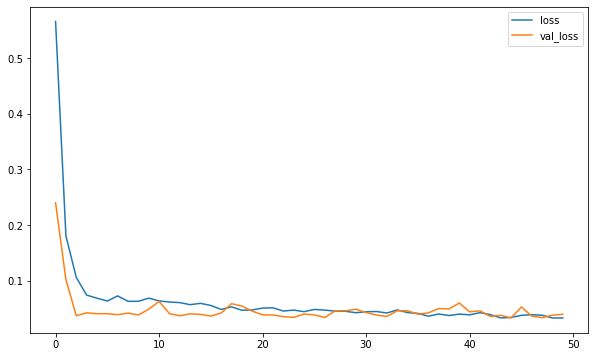

In [248]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [249]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [250]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [251]:
validation_generator[0]

(array([[[-0.67885026],
         [-1.05352659],
         [-1.47405696],
         [-0.83657786],
         [-0.31090033],
         [ 0.10203626],
         [ 0.29325874],
         [ 0.1999222 ],
         [ 0.69390816],
         [ 0.22190814],
         [ 0.02120974],
         [-0.34907146],
         [-0.66982345],
         [-0.83058513],
         [-1.21446997],
         [-0.86471081],
         [-0.35110789],
         [-0.04184085],
         [-0.08357059],
         [-0.16255953],
         [ 0.18301706],
         [-0.08302549],
         [ 0.04819762],
         [-0.35829712]],
 
        [[-1.05352659],
         [-1.47405696],
         [-0.83657786],
         [-0.31090033],
         [ 0.10203626],
         [ 0.29325874],
         [ 0.1999222 ],
         [ 0.69390816],
         [ 0.22190814],
         [ 0.02120974],
         [-0.34907146],
         [-0.66982345],
         [-0.83058513],
         [-1.21446997],
         [-0.86471081],
         [-0.35110789],
         [-0.04184085],
         [-0.

In [252]:
test_scaled

array([[-0.67885026],
       [-1.05352659],
       [-1.47405696],
       [-0.83657786],
       [-0.31090033],
       [ 0.10203626],
       [ 0.29325874],
       [ 0.1999222 ],
       [ 0.69390816],
       [ 0.22190814],
       [ 0.02120974],
       [-0.34907146],
       [-0.66982345],
       [-0.83058513],
       [-1.21446997],
       [-0.86471081],
       [-0.35110789],
       [-0.04184085],
       [-0.08357059],
       [-0.16255953],
       [ 0.18301706],
       [-0.08302549],
       [ 0.04819762],
       [-0.35829712],
       [-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0

In [253]:
y_pred = model.predict(validation_generator)

In [254]:
y_pred

array([[-0.6966436 ],
       [-0.89021873],
       [-0.95855093],
       [-0.85001445],
       [-0.19725268],
       [ 0.04137607],
       [ 0.25981733],
       [ 0.69774866],
       [ 0.805045  ],
       [ 0.504269  ],
       [ 0.17473239],
       [-0.10427853],
       [-0.5004118 ],
       [-0.6563876 ],
       [-0.8024983 ],
       [-0.5279578 ],
       [-0.04277608],
       [ 0.22602406],
       [ 0.3602823 ],
       [ 0.8859712 ],
       [ 0.59269166],
       [ 0.23833014],
       [-0.07193533],
       [-0.32089126],
       [-0.753393  ],
       [-0.94956595],
       [-1.0810727 ],
       [-0.76934266],
       [-0.41012225],
       [-0.16012909],
       [-0.0412228 ],
       [ 0.4259875 ],
       [ 0.31369436],
       [ 0.16659467],
       [-0.09547444],
       [-0.38501173],
       [-0.692966  ],
       [-0.9637929 ],
       [-1.0066043 ],
       [-0.7307632 ],
       [-0.2531712 ],
       [-0.07516451],
       [ 0.16578189],
       [ 0.512511  ],
       [ 0.61452436],
       [ 0

In [255]:
len(y_pred)

48

In [256]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [257]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8612451304181252 
 mae: 0.1525974596800739 
 mse: 0.03933102795158836 
 rmse: 0.19832051823144362


In [258]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [259]:
train.shape

(501, 1)

In [260]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.35387189493838733 
 mae: 0.3318535817237413 
 mse: 0.18303851366531587 
 rmse: 0.42783000556916984


#### Inverse Transformations and Comparing

In [261]:
true_predictions = scaler.inverse_transform(test_predictions)

In [262]:
test

amount
DATE              
2013-10-01  90.998
2013-11-01  80.069
2013-12-01  67.803
2014-01-01  86.397
2014-02-01 101.731
2014-03-01 113.776
2014-04-01 119.353
2014-05-01 116.631
2014-06-01 131.040
2014-07-01 117.272
2014-08-01 111.418
2014-09-01 100.617
2014-10-01  91.261
2014-11-01  86.572
2014-12-01  75.375
2015-01-01  85.577
2015-02-01 100.558
2015-03-01 109.579
2015-04-01 108.362
2015-05-01 106.058
2015-06-01 116.138
2015-07-01 108.378
2015-08-01 112.205
2015-09-01 100.348
2015-10-01  93.932
2015-11-01  85.864
2015-12-01  76.975
2016-01-01  92.811
2016-02-01 101.974
2016-03-01 116.179
2016-04-01 124.211
2016-05-01 121.543
2016-06-01 132.987
2016-07-01 124.851
2016-08-01 121.332
2016-09-01 108.036
2016-10-01 101.384
2016-11-01  86.665
2016-12-01  81.257
2017-01-01  94.245
2017-02-01 112.388
2017-03-01 119.698
2017-04-01 123.228
2017-05-01 116.064
2017-06-01 123.087
2017-07-01 116.264
2017-08-01 113.172
2017-09-01  97.912
2017-10-01  90.473
2017-11-01  77.438
2017-12-01  75.812
2018-01-01  83.434
2018-02-01  99.490
2018-03-01 107.315
2018-04-01 112.431
2018-05-01 110.354
2018-06-01 124.584
2018-07-01 117.222
2018-08-01 112.678
2018-09-01 103.312
2018-10-01  92.132
2018-11-01  82.435
2018-12-01  76.761
2019-01-01  86.999
2019-02-01  98.112
2019-03-01 116.172
2019-04-01 114.970
2019-05-01 114.561
2019-06-01 124.960
2019-07-01 110.263
2019-08-01 102.609
2019-09-01 101.587

In [263]:
test['PredictionsTanh'] = true_predictions

In [264]:
test

amount  Predictions
DATE                           
2013-10-01  90.998       85.745
2013-11-01  80.069       77.210
2013-12-01  67.803       76.375
2014-01-01  86.397       87.107
2014-02-01 101.731      101.417
2014-03-01 113.776      108.595
2014-04-01 119.353      111.761
2014-05-01 116.631      124.492
2014-06-01 131.040      129.462
2014-07-01 117.272      123.318
2014-08-01 111.418      113.912
2014-09-01 100.617      101.746
2014-10-01  91.261       89.615
2014-11-01  86.572       80.906
2014-12-01  75.375       80.933
2015-01-01  85.577       93.196
2015-02-01 100.558      107.831
2015-03-01 109.579      114.088
2015-04-01 108.362      117.273
2015-05-01 106.058      131.783
2015-06-01 116.138      134.365
2015-07-01 108.378      127.588
2015-08-01 112.205      117.480
2015-09-01 100.348      104.722
2015-10-01  93.932       92.070
2015-11-01  85.864       83.222
2015-12-01  76.975       84.013
2016-01-01  92.811       97.310
2016-02-01 101.974      112.141
2016-03-01 116.179      118.763
2016-04-01 124.211      121.916
2016-05-01 121.543      136.256
2016-06-01 132.987      138.111
2016-07-01 124.851      130.834
2016-08-01 121.332      119.942
2016-09-01 108.036      106.522
2016-10-01 101.384       93.365
2016-11-01  86.665       84.461
2016-12-01  81.257       86.257
2017-01-01  94.245      100.986
2017-02-01 112.388      115.936
2017-03-01 119.698      122.431
2017-04-01 123.228      125.672
2017-05-01 116.064      140.414
2017-06-01 123.087      140.888
2017-07-01 116.264      133.002
2017-08-01 113.172      121.413
2017-09-01  97.912      107.455
2017-10-01  90.473       93.961
2017-11-01  77.438       85.264
2017-12-01  75.812       88.234
2018-01-01  83.434      104.075
2018-02-01  99.490      118.829
2018-03-01 107.315      125.022
2018-04-01 112.431      128.453
2018-05-01 110.354      143.747
2018-06-01 124.584      142.577
2018-07-01 117.222      134.249
2018-08-01 112.678      122.054
2018-09-01 103.312      107.693
2018-10-01  92.132       94.013
2018-11-01  82.435       85.681
2018-12-01  76.761       89.859
2019-01-01  86.999      106.559
2019-02-01  98.112      120.940
2019-03-01 116.172      126.769
2019-04-01 114.970      130.470
2019-05-01 114.561      146.243
2019-06-01 124.960      143.414
2019-07-01 110.263      134.741
2019-08-01 102.609      122.042
2019-09-01 101.587      107.400

<AxesSubplot:xlabel='DATE'>

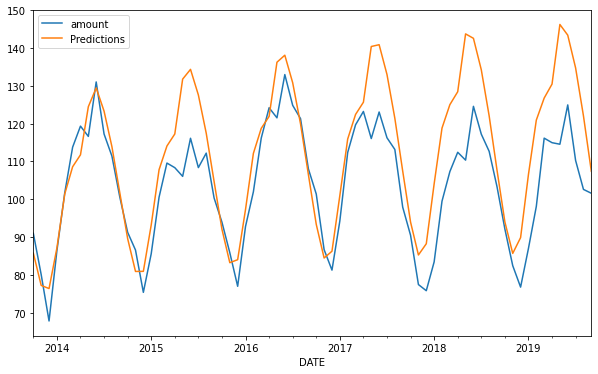

In [265]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [266]:
eval_metrics(test.amount, test.Predictions)

r2_score: 0.3538718483027067 
 mae: 9.679719116210938 
 mse: 155.7309568777477 
 rmse: 12.479221004443655


### with "relu" activation function

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [268]:
n_features = 1

In [269]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')

In [270]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [271]:
from tensorflow.keras.callbacks import EarlyStopping

In [272]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 25)

In [273]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 16)

In [274]:
len(validation_generator)

3

In [275]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6518 - val_loss: 0.2999
Epoch 2/50
120/120 [==============================] - 1s 4ms/step - loss: 0.5159 - val_loss: 0.2588
Epoch 3/50
120/120 [==============================] - 1s 4ms/step - loss: 0.4625 - val_loss: 0.2401
Epoch 4/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4484 - val_loss: 0.2293
Epoch 5/50
120/120 [==============================] - 1s 5ms/step - loss: 0.3231 - val_loss: 0.1251
Epoch 6/50
120/120 [==============================] - 1s 5ms/step - loss: 0.2187 - val_loss: 0.0654
Epoch 7/50
120/120 [==============================] - 1s 5ms/step - loss: 0.1454 - val_loss: 0.0422
Epoch 8/50
120/120 [==============================] - 1s 5ms/step - loss: 0.1195 - val_loss: 0.0388
Epoch 9/50
120/120 [==============================] - 1s 5ms/step - loss: 0.1180 - val_loss: 0.0361
Epoch 10/50
120/120 [==============================] - 1s 4ms/step - loss: 0.0999 - val_loss: 0.0394

<AxesSubplot:>

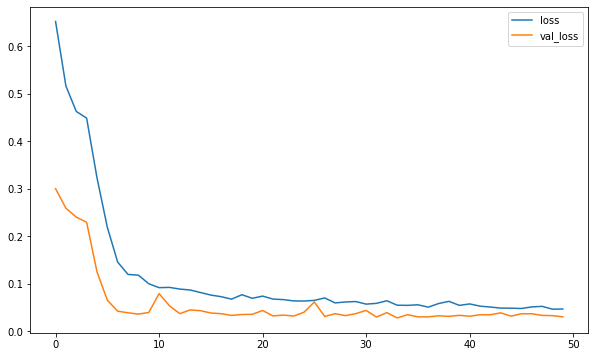

In [276]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [277]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [278]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [279]:
y_pred = model.predict(validation_generator)

In [280]:
y_pred

array([[-0.808318  ],
       [-1.0250168 ],
       [-1.1513382 ],
       [-0.9269521 ],
       [-0.3198217 ],
       [-0.01699284],
       [ 0.32554042],
       [ 0.599705  ],
       [ 0.5803564 ],
       [ 0.61185235],
       [ 0.24541163],
       [-0.14254059],
       [-0.55905694],
       [-0.7637696 ],
       [-1.0239114 ],
       [-0.769254  ],
       [-0.15583861],
       [ 0.24441415],
       [ 0.46068722],
       [ 0.6054242 ],
       [ 0.42832726],
       [ 0.28691548],
       [-0.07774103],
       [-0.40509856],
       [-0.84661275],
       [-1.0710849 ],
       [-1.248784  ],
       [-0.85184675],
       [-0.49124575],
       [-0.1459887 ],
       [ 0.07829396],
       [ 0.25325143],
       [ 0.21089211],
       [ 0.3083526 ],
       [ 0.03699758],
       [-0.32420713],
       [-0.7234865 ],
       [-1.0408647 ],
       [-1.1236135 ],
       [-0.72366357],
       [-0.30325267],
       [-0.05584972],
       [ 0.29605   ],
       [ 0.4258814 ],
       [ 0.38203046],
       [ 0

In [281]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [282]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8933267028067599 
 mae: 0.1385204882452372 
 mse: 0.030237284257038272 
 rmse: 0.1738887122760942


In [283]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [284]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.6606485726832569 
 mae: 0.256069013613084 
 mse: 0.09613322865801838 
 rmse: 0.3100535899776333


#### Inverse Transformations and Comparing

In [285]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [286]:
test['Predictions_Relu'] = true_predictions_relu

In [287]:
test

amount  Predictions  Predictions_Relu
DATE                                             
2013-10-01  90.998       85.745            83.588
2013-11-01  80.069       77.210            73.636
2013-12-01  67.803       76.375            70.451
2014-01-01  86.397       87.107            80.857
2014-02-01 101.731      101.417            94.735
2014-03-01 113.776      108.595           104.240
2014-04-01 119.353      111.761           110.969
2014-05-01 116.631      124.492           116.585
2014-06-01 131.040      129.462           120.224
2014-07-01 117.272      123.318           119.111
2014-08-01 111.418      113.912           111.020
2014-09-01 100.617      101.746            98.242
2014-10-01  91.261       89.615            85.154
2014-11-01  86.572       80.906            74.725
2014-12-01  75.375       80.933            69.780
2015-01-01  85.577       93.196            78.289
2015-02-01 100.558      107.831            93.276
2015-03-01 109.579      114.088           103.016
2015-04-01 108.362      117.273           109.530
2015-05-01 106.058      131.783           115.458
2015-06-01 116.138      134.365           119.542
2015-07-01 108.378      127.588           119.351
2015-08-01 112.205      117.480           111.441
2015-09-01 100.348      104.722            98.774
2015-10-01  93.932       92.070            85.515
2015-11-01  85.864       83.222            74.676
2015-12-01  76.975       84.013            69.437
2016-01-01  92.811       97.310            77.449
2016-02-01 101.974      112.141            91.095
2016-03-01 116.179      118.763           101.516
2016-04-01 124.211      121.916           109.030
2016-05-01 121.543      136.256           115.440
2016-06-01 132.987      138.111           120.085
2016-07-01 124.851      130.834           120.467
2016-08-01 121.332      119.942           113.826
2016-09-01 108.036      106.522           101.095
2016-10-01 101.384       93.365            87.706
2016-11-01  86.665       84.461            76.376
2016-12-01  81.257       86.257            69.976
2017-01-01  94.245      100.986            76.138
2017-02-01 112.388      115.936            89.771
2017-03-01 119.698      122.431           100.731
2017-04-01 123.228      125.672           108.420
2017-05-01 116.064      140.414           114.928
2017-06-01 123.087      140.888           119.939
2017-07-01 116.264      133.002           120.894
2017-08-01 113.172      121.413           114.859
2017-09-01  97.912      107.455           102.404
2017-10-01  90.473       93.961            88.966
2017-11-01  77.438       85.264            77.399
2017-12-01  75.812       88.234            70.189
2018-01-01  83.434      104.075            74.742
2018-02-01  99.490      118.829            87.776
2018-03-01 107.315      125.022            99.311
2018-04-01 112.431      128.453           107.313
2018-05-01 110.354      143.747           113.974
2018-06-01 124.584      142.577           119.311
2018-07-01 117.222      134.249           120.932
2018-08-01 112.678      122.054           116.180
2018-09-01 103.312      107.693           104.331
2018-10-01  92.132       94.013            90.813
2018-11-01  82.435       85.681            78.758
2018-12-01  76.761       89.859            70.750
2019-01-01  86.999      106.559            73.425
2019-02-01  98.112      120.940            86.274
2019-03-01 116.172      126.769            98.312
2019-04-01 114.970      130.470           106.666
2019-05-01 114.561      146.243           113.455
2019-06-01 124.960      143.414           119.081
2019-07-01 110.263      134.741           121.227
2019-08-01 102.609      122.042           117.351
2019-09-01 101.587      107.400           105.978

<AxesSubplot:xlabel='DATE'>

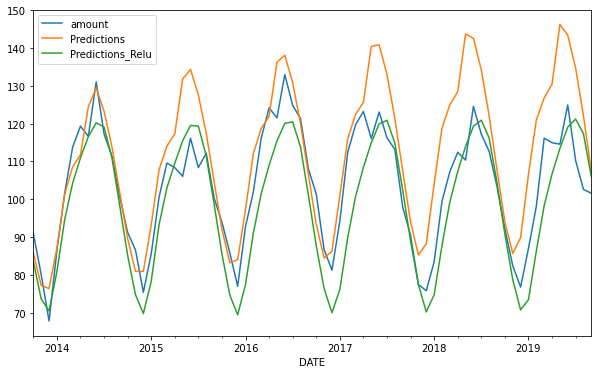

In [288]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [289]:
eval_metrics(test.amount, test.Predictions_Relu)

r2_score: 0.6606485712660185 
 mae: 7.469185596889919 
 mse: 81.79108521390111 
 rmse: 9.0438423921418


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [290]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [291]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 16)

In [292]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=50)

Epoch 1/50
35/35 [==============================] - 1s 5ms/step - loss: 0.6297
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.4869
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.2772
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.1091
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0857
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0859
Epoch 7/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 8/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0662
Epoch 9/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0710
Epoch 10/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0675
Epoch 11/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 12/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0644
Epoch 13/50
35/35 [==============================

In [293]:
scaled_full_data.shape

(573, 1)

In [294]:
scaled_full_data[-length:].shape

(24, 1)

In [295]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [296]:
forecast = scaler.inverse_transform(forecast)

In [297]:
forecast

array([[ 87.75528 ],
       [ 79.87508 ],
       [ 78.31874 ],
       [ 86.730095],
       [ 99.041275],
       [105.857956],
       [111.1688  ],
       [118.28868 ],
       [122.21555 ],
       [116.78021 ],
       [107.03886 ],
       [ 95.82468 ],
       [ 85.20561 ],
       [ 77.65977 ],
       [ 77.55505 ],
       [ 88.61556 ],
       [101.327675],
       [107.26561 ],
       [112.82244 ],
       [120.65035 ],
       [123.46208 ],
       [116.55987 ],
       [106.48669 ],
       [ 95.30475 ]], dtype=float32)

In [298]:
df

amount
DATE              
1972-01-01  59.962
1972-02-01  67.061
1972-03-01  74.235
1972-04-01  78.112
1972-05-01  84.764
1972-06-01 100.596
1972-07-01 100.126
1972-08-01  96.361
1972-09-01  85.801
1972-10-01  70.393
1972-11-01  60.807
1972-12-01  58.660
1973-01-01  61.100
1973-02-01  72.206
1973-03-01  80.098
1973-04-01  83.906
1973-05-01  87.371
1973-06-01 109.747
1973-07-01 107.375
1973-08-01  99.663
1973-09-01  91.627
1973-10-01  75.305
1973-11-01  65.934
1973-12-01  61.530
1974-01-01  62.980
1974-02-01  75.345
1974-03-01  84.268
1974-04-01  84.588
1974-05-01  90.540
1974-06-01 109.903
1974-07-01 103.890
1974-08-01 101.026
1974-09-01  89.476
1974-10-01  73.695
1974-11-01  66.157
1974-12-01  61.065
1975-01-01  64.266
1975-02-01  75.417
1975-03-01  85.169
1975-04-01  85.092
1975-05-01  97.355
1975-06-01 113.525
1975-07-01 108.145
1975-08-01 104.825
1975-09-01  90.116
1975-10-01  75.719
1975-11-01  70.217
1975-12-01  62.744
1976-01-01  61.942
1976-02-01  74.060
1976-03-01  86.965
1976-04-01  90.131
1976-05-01  94.154
1976-06-01 110.026
1976-07-01 107.462
1976-08-01 103.818
1976-09-01  92.238
1976-10-01  75.103
1976-11-01  67.532
1976-12-01  62.483
1977-01-01  63.768
1977-02-01  75.061
1977-03-01  90.021
1977-04-01  92.665
1977-05-01  99.120
1977-06-01 114.723
1977-07-01 112.330
1977-08-01 106.414
1977-09-01  91.722
1977-10-01  76.025
1977-11-01  67.394
1977-12-01  61.441
1978-01-01  61.888
1978-02-01  72.871
1978-03-01  83.931
1978-04-01  89.059
1978-05-01  92.452
1978-06-01 111.326
1978-07-01 106.925
1978-08-01 103.691
1978-09-01  90.620
1978-10-01  79.184
1978-11-01  67.885
1978-12-01  62.403
1979-01-01  63.012
1979-02-01  73.941
1979-03-01  86.427
1979-04-01  91.203
1979-05-01  94.701
1979-06-01 110.103
1979-07-01 107.154
1979-08-01 106.773
1979-09-01  95.316
1979-10-01  79.598
1979-11-01  67.893
1979-12-01  63.285
1980-01-01  66.983
1980-02-01  76.444
1980-03-01  85.890
1980-04-01  87.998
1980-05-01  92.173
1980-06-01 108.467
1980-07-01 107.874
1980-08-01 107.857
1980-09-01  90.669
1980-10-01  76.228
1980-11-01  66.487
1980-12-01  63.865
1981-01-01  60.560
1981-02-01  76.485
1981-03-01  86.615
1981-04-01  89.034
1981-05-01  93.698
1981-06-01 110.684
1981-07-01 110.784
1981-08-01 106.120
1981-09-01  91.471
1981-10-01  76.925
1981-11-01  71.028
1981-12-01  66.599
1982-01-01  62.075
1982-02-01  77.029
1982-03-01  88.503
1982-04-01  86.244
1982-05-01  93.338
1982-06-01 106.934
1982-07-01 101.146
1982-08-01  98.201
1982-09-01  86.186
1982-10-01  72.074
1982-11-01  66.028
1982-12-01  61.469
1983-01-01  63.526
1983-02-01  74.365
1983-03-01  86.651
1983-04-01  83.531
1983-05-01  94.351
1983-06-01 110.226
1983-07-01 107.551
1983-08-01 105.297
1983-09-01  95.891
1983-10-01  79.065
1983-11-01  70.355
1983-12-01  65.587
1984-01-01  67.001
1984-02-01  85.614
1984-03-01  96.775
1984-04-01 101.825
1984-05-01 108.334
1984-06-01 128.840
1984-07-01 125.127
1984-08-01 116.608
1984-09-01 106.888
1984-10-01  88.263
1984-11-01  80.385
1984-12-01  73.974
1985-01-01  76.174
1985-02-01  86.612
1985-03-01 101.235
1985-04-01 104.867
1985-05-01 114.318
1985-06-01 130.597
1985-07-01 124.517
1985-08-01 117.446
1985-09-01 104.065
1985-10-01  86.226
1985-11-01  74.659
1985-12-01  70.633
1986-01-01  73.682
1986-02-01  88.936
1986-03-01 100.029
1986-04-01 104.301
1986-05-01 113.296
1986-06-01 127.323
1986-07-01 121.323
1986-08-01 119.079
1986-09-01  96.870
1986-10-01  86.412
1986-11-01  76.972
1986-12-01  70.620
1987-01-01  73.948
1987-02-01  94.537
1987-03-01 103.602
1987-04-01 106.819
1987-05-01 116.811
1987-06-01 132.008
1987-07-01 127.404
1987-08-01 123.675
1987-09-01 106.722
1987-10-01  89.404
1987-11-01  84.630
1987-12-01  79.702
1988-01-01  79.900
1988-02-01  98.017
1988-03-01 115.092
1988-04-01 119.372
1988-05-01 130.041
1988-06-01 150.930
1988-07-01 145.441
1988-08-01 140.743
1988-09-01 117.383
1988-10-01 100.098
1988-11-01  87.776
1988-12-01  83.095
1989-01-01  87.618
1989-02-01 104.350
1989-03-01 115.434
1989-04-01 121.182
1989-05-01 126.101
198

In [299]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [300]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [301]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [302]:
forecast_df

Forecast
2019-10-01    87.755
2019-11-01    79.875
2019-12-01    78.319
2020-01-01    86.730
2020-02-01    99.041
2020-03-01   105.858
2020-04-01   111.169
2020-05-01   118.289
2020-06-01   122.216
2020-07-01   116.780
2020-08-01   107.039
2020-09-01    95.825
2020-10-01    85.206
2020-11-01    77.660
2020-12-01    77.555
2021-01-01    88.616
2021-02-01   101.328
2021-03-01   107.266
2021-04-01   112.822
2021-05-01   120.650
2021-06-01   123.462
2021-07-01   116.560
2021-08-01   106.487
2021-09-01    95.305

<AxesSubplot:>

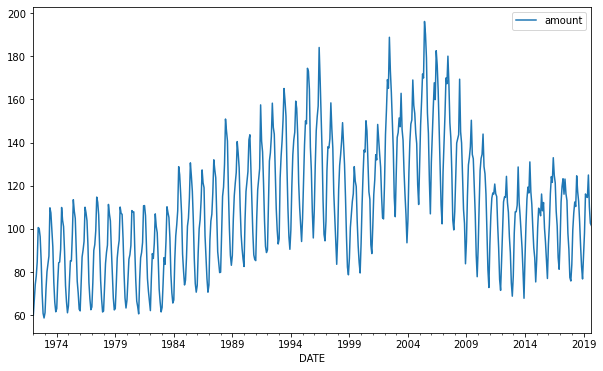

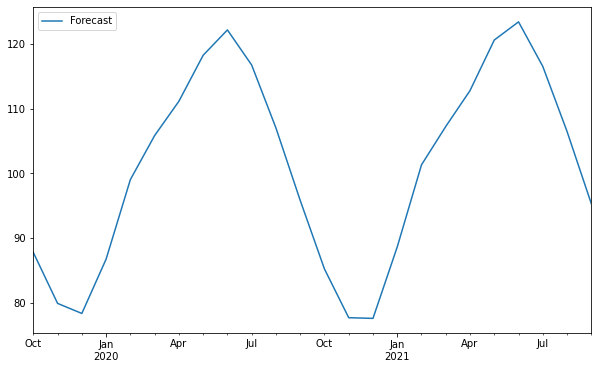

In [303]:
df.plot()
forecast_df.plot()

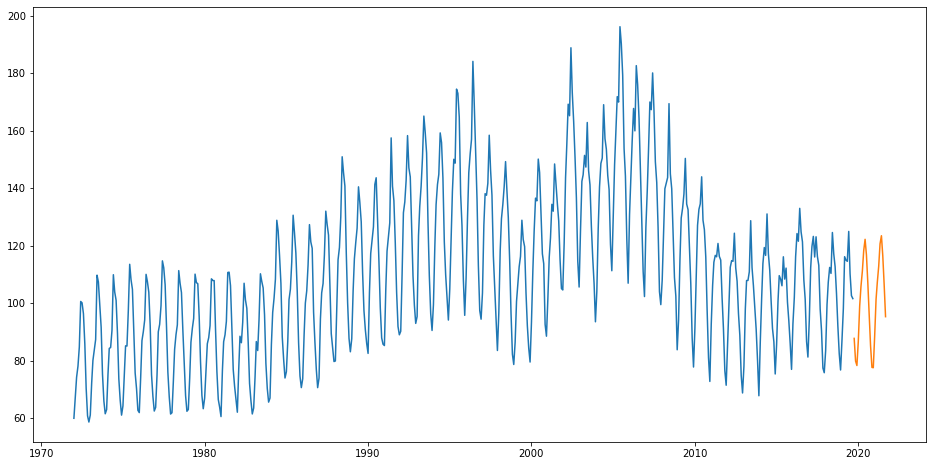

In [304]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

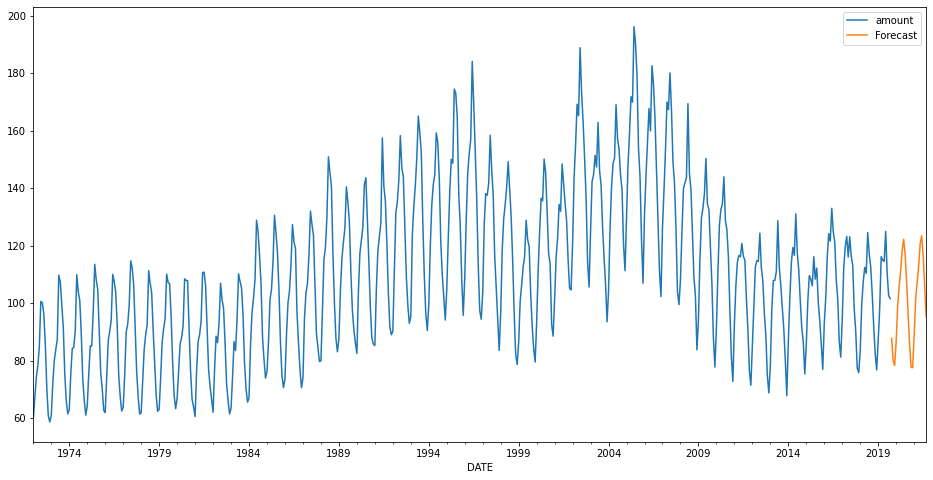

In [305]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(594.0, 598.0)

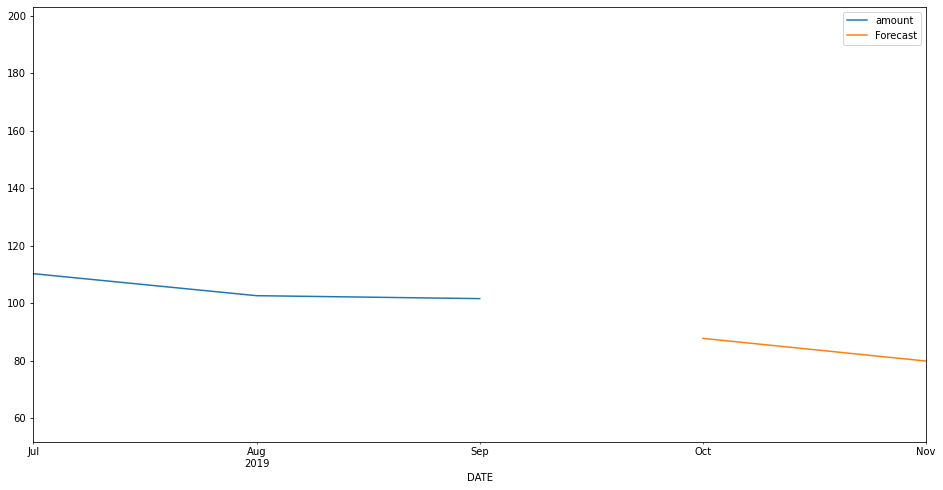

In [306]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2019-07-01', '2019-11-01')

In [307]:
model.save("RNN_assignment3.h5")

**at the end of the assignmnet_3**